# Setup

In [ ]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Read in data
df = pd.read_csv('/content/drive/MyDrive/Atlanta-airport-temperature.csv')
df.head()

,STATION,NAME,DATE,TAVG,TMAX,TMIN
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2000-01-01,58.0,66,49
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2000-01-02,60.0,68,52
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2000-01-03,65.0,73,57
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2000-01-04,52.0,64,40
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2000-01-05,41.0,48,33


In [ ]:
# Organizing data
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Dropping missing data and irrelevant columns
df = df[['TAVG','TMAX','TMIN']]
df.dropna(inplace=True)
df.head()

,TAVG,TMAX,TMIN
DATE,,,
2000-01-01,58.0,66,49
2000-01-02,60.0,68,52
2000-01-03,65.0,73,57
2000-01-04,52.0,64,40
2000-01-05,41.0,48,33


# Data Visualization #

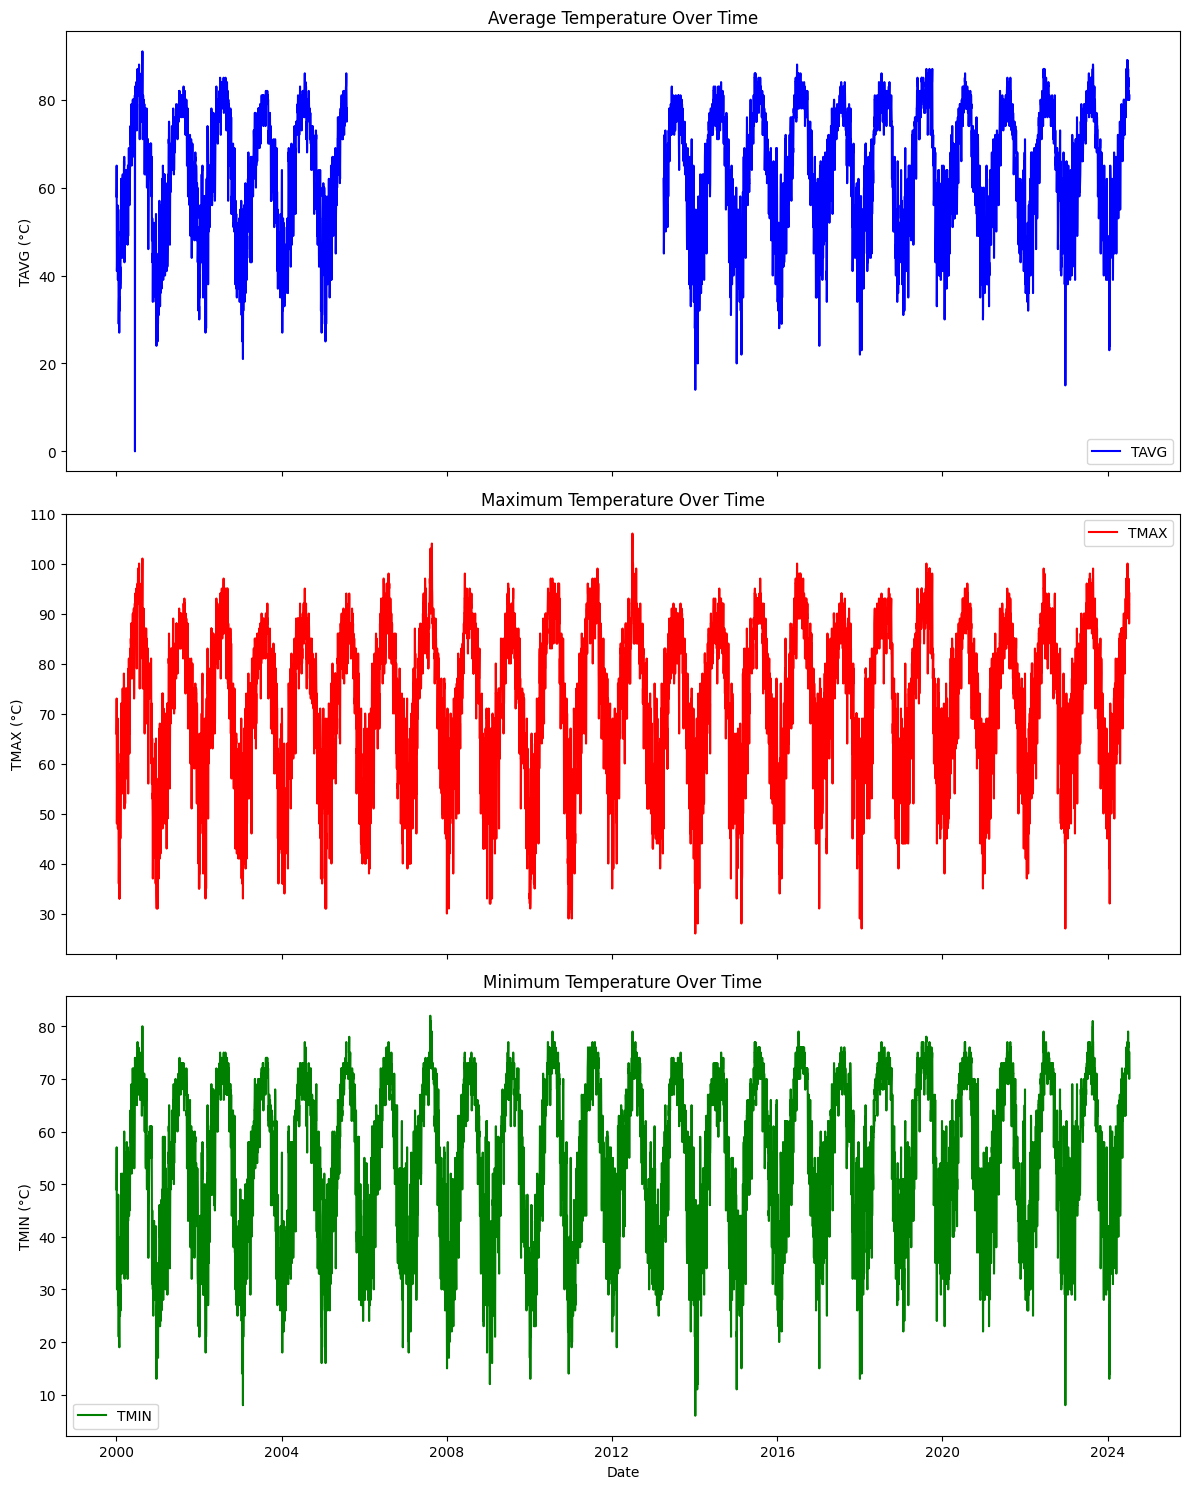

In [ ]:
# Creating a figure and axis for each temperature type
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plotting TAVG over time
axs[0].plot(df.index, df['TAVG'], label='TAVG', color='blue')
axs[0].set_title('Average Temperature Over Time')
axs[0].set_ylabel('TAVG (°F)')
axs[0].legend()

# Plotting TMAX over time
axs[1].plot(df.index, df['TMAX'], label='TMAX', color='red')
axs[1].set_title('Maximum Temperature Over Time')
axs[1].set_ylabel('TMAX (°F)')
axs[1].legend()

# Plotting TMIN over time
axs[2].plot(df.index, df['TMIN'], label='TMIN', color='green')
axs[2].set_title('Minimum Temperature Over Time')
axs[2].set_ylabel('TMIN (°F)')
axs[2].set_xlabel('Date')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
# Plotting colinearity of columns
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


# LSTM Model #

## Prepare the Data ##

**Train / Test Data Splitting**
Train data is used to build the model, while test data is used to validate its performance and ensure it can generalize well to new data. Generally a 80/20 train-test split is sufficient.

**Sequence Lengths**

*Long Sequence Lengths*

- Capturing Long-term Dependencies
   - Longer sequences allow the LSTM to capture relations where past information over long periods is relevant.
   
- Increased Computational Cost
   - Processing longer sequences requires more memory and computational power, which can lead to longer training times
   
- Risk of Overfitting
   - With longer sequences, there's a higher risk of the model overfitting to the training data, especially if the training dataset is not large enough.

*Short Sequence Lengths*

- Faster Computation
   - Shorter sequences reduce computational load
   
- Focus on Local Patterns
   - Short sequences force the model to focus on more local, immediate patterns.
   
- Potential Loss of Long-term Information
   - Short sequences might miss out on capturing important long-term dependencies.
   
- Reduced Overfitting Risk
   - With fewer data points per sequence, the risk of overfitting is lower.

In [ ]:
# TAVG data
df_AVG = df[['Date','TAVG']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_AVG)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create the sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Use the past 60 days to predict the next day
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


##Build the model##

Epoch 1/20
223/223 [==============================] - 19s 66ms/step - loss: 0.0245 - val_loss: 0.0061
Epoch 2/20
223/223 [==============================] - 14s 62ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 3/20
223/223 [==============================] - 14s 63ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 4/20
223/223 [==============================] - 14s 62ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 5/20
223/223 [==============================] - 14s 62ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 6/20
223/223 [==============================] - 14s 62ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/20
223/223 [==============================] - 14s 62ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 8/20
223/223 [==============================] - 13s 59ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 9/20
223/223 [==============================] - 13s 59ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 10/20
223/223 [==============================] - 13s 60ms/step - loss: 0.005

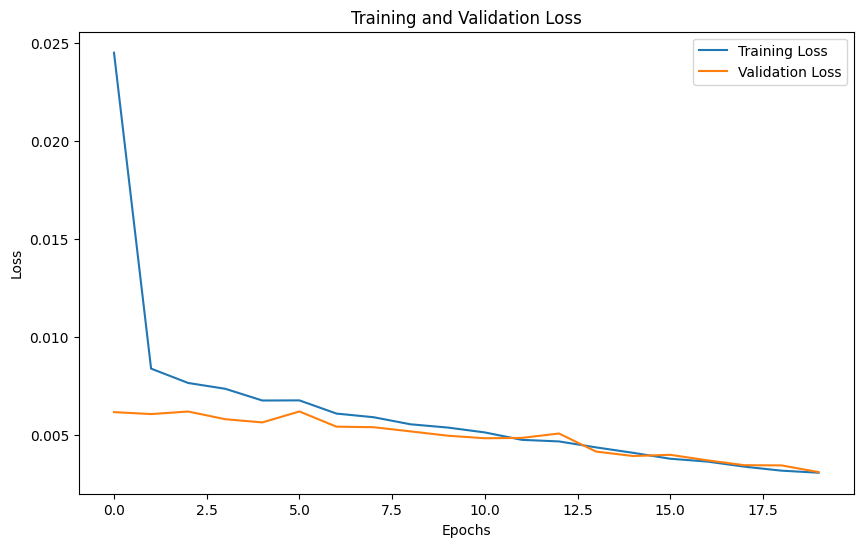

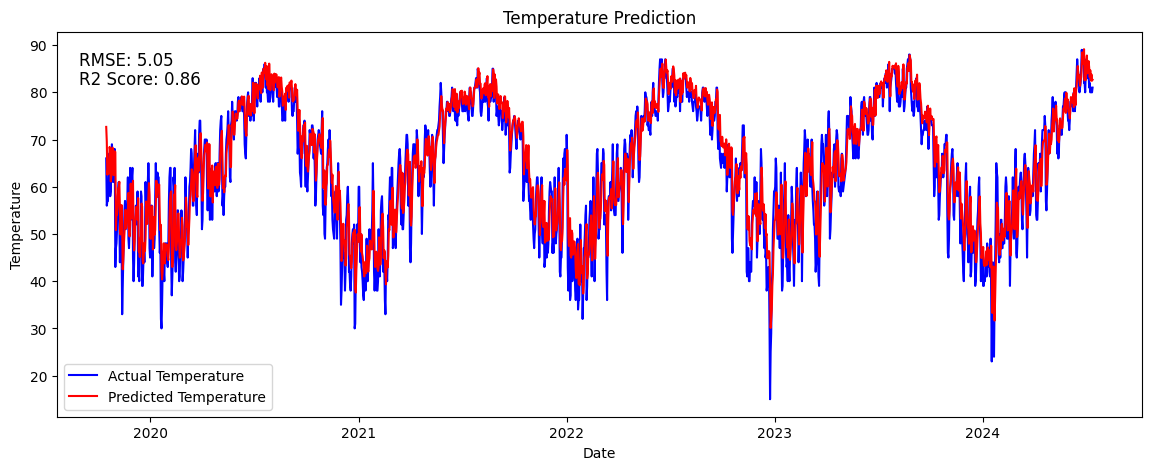

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Converting predictions to original units
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
r2 = r2_score(y_test_actual, predictions)

##Visualize Performances##

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + seq_length:], df['TAVG'][train_size + seq_length:], color='blue', label='Actual Temperature')
plt.plot(df.index[train_size + seq_length:], predictions, color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# Add performance metrics to the plot
plt.text(0.02, 0.95, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.02, 0.90, f'R2 Score: {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

# Improvements #

**METRICS**

*Mean Squared Error (MSE)*

The average squared difference between the estimated values and the actual value. Use for loss calculations.

$$ \frac{1}{n} \sum_{i = 1}^n (Y_i - \hat{Y}_i )^2 $$


*Root Mean Squared Error (RMSE)*

The root of the MSE. The benefit is that the metric returned is in the same units as the input. Use for contextualizing performance.

$$ \sqrt{ \frac{\sum_{i = 1}^n (Y_i - \hat{Y}_i )^2 }{n} } $$

*R Squared*

How much of the variance in the dependent variable can be explained by the independent variable(s). R Squared is on a scale from 0 to 1: the higher the number the better the performance. Use to determine model performance.

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2 } $$

---


**CAPACITY**

<div style="text-align: center;">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20230829151403/Bias-and-Variance-in-Machine-Learning-1024.webp" alt="Alt text" height="200">
</div>



*Underfitting*

A model is too simple and results in poor performance on both the training data and test (unseen) data.
Solutions include:
- Increasing complexity
- Include more features
- Train for more epochs
- Reduce regularizations

*Overfitting*

When a model is too complex and learns not only the underlying structure, but also noise and random fluctuations in the training data. It results in good performance on the training data but poor performance on test (unseen) unseen data.
Solutions include:
- Reducing complexity
- Regularizations
- Increasing training data


*Loss*

| Training\Validation | High Loss | Low Loss |
|---------------------|----------------|---------------|
| **High Loss**| Underfitting | Check Code         |
| **Low Loss** | Overfitting  | Appropriate        |




Now that we have created a baseline model we can continue to test different approaches to improve the performance of our model. To determine whether or not a new approach is benificial we need to look at the metrics of our model.

TLDR; increase complexity until overfitting occurs.

## Data Manipulation ##

**Increasing Features (TMAX, TMIN)**

Principal Component Analysis (PCA):

- Collinearity Mitigation: PCA transforms the correlated features into uncorrelated principal components

- Improved Model Performance: The principal components capture the essential information, leading to more robust and generalizable models.

- Noise Reduction: PCA can filter out the noise in the data by focusing on the components that capture the most variance.

- Dimensionality Reduction: reduces the number of variables

- Computational Efficiency: Working with a reduced set of principal components can significantly decrease the computational cost.


Normalizing Data:

- Adjusts the values measured on different scales to a common scale without distorting differences.
- Normalization ensures that no feature dominates the learning process due to its scale.


## Model Architecture ##

Adding Layers

## Hyperparameter Tuning

Sequence Length

Drop Out Rate

# Resources #

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/